# Projeto de Previsão da Inflação (IPCA) no Brasil

Este notebook tem como objetivo construir um modelo simples para prever a variação mensal do IPCA (Índice Nacional de Preços ao Consumidor Amplo) utilizando seus valores passados (lags) como features. A inflação é um indicador econômico crucial, e este projeto serve como um exercício prático para aplicar conceitos de análise de séries temporais e machine learning.

**Objetivos:**
* Coletar e tratar os dados históricos do IPCA.
* Realizar uma análise exploratória para entender o comportamento da inflação.
* Criar features baseadas em lags.
* Treinar um modelo de Regressão Linear.
* Avaliar o desempenho do modelo.

*Este projeto foi desenvolvido como parte do meu aprendizado em Ciência de Dados, buscando aplicar técnicas de modelagem preditiva a um indicador econômico fundamental para o Brasil, o IPCA. A ideia é entender o processo de construção de um modelo do início ao fim.*

In [2]:
!pip install python-bcb

In [31]:
from bcb import sgs
import pandas as pd
import numpy as np

## 1. Coleta de Dados

Para este projeto, a série histórica do IPCA mensal foi obtida diretamente da API do Sistema Gerenciador de Séries Temporais (SGS) do Banco Central do Brasil (BCB), utilizando a biblioteca `python-bcb`.

A série escolhida é a de código **433**, que representa a variação percentual mensal do IPCA. A coleta de dados foi iniciada a partir de janeiro de 2000, o que nos fornece um histórico de mais de 20 anos para análise e modelagem.

In [35]:
ipca_dados = sgs.get({'IPCA': 433}, start='2000-01-01')

In [5]:
print("Primeiros dados:")
print(ipca_dados.head())
print("\nÚltimos dados:")
print(ipca_dados.tail())

Primeiros dados:
            IPCA
Date            
2000-01-01  0.62
2000-02-01  0.13
2000-03-01  0.22
2000-04-01  0.42
2000-05-01  0.01

Últimos dados:
            IPCA
Date            
2024-12-01  0.52
2025-01-01  0.16
2025-02-01  1.31
2025-03-01  0.56
2025-04-01  0.43


Os dados foram carregados em um DataFrame do Pandas. O índice do DataFrame é composto pelas datas (início de cada mês), e há uma única coluna, 'IPCA', com a respectiva variação percentual. Os dados mais recentes no momento da coleta chegam até abril de 2025.

## 2. Análise Exploratória dos Dados (EDA)

Nesta etapa, exploraremos os dados do IPCA para entender melhor sua estrutura, distribuição e comportamento ao longo do tempo. Isso é fundamental antes de qualquer tentativa de modelagem.

In [6]:
print(ipca_dados.shape)

(304, 1)


In [7]:
ipca_dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 304 entries, 2000-01-01 to 2025-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPCA    304 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


O comando `.info()` revela que o DataFrame `ipca_dados` possui 304 entradas (meses) e uma coluna ('IPCA'). Não foram encontrados valores nulos (Non-Null Count é 304), e o tipo de dado (Dtype) para o IPCA é `float64`, o que é apropriado para valores numéricos. O índice é do tipo `DatetimeIndex`, o que facilita manipulações de séries temporais.

In [8]:
print(ipca_dados['IPCA'].describe())

count    304.000000
mean       0.502632
std        0.395551
min       -0.680000
25%        0.260000
50%        0.450000
75%        0.675000
max        3.020000
Name: IPCA, dtype: float64


As estatísticas descritivas fornecem um resumo interessante da inflação mensal no período de janeiro de 2000 a abril de 2025:
* A inflação mensal média (`mean`) foi de aproximadamente **0.503%**.
* A mediana (`50%`), que é o valor central, foi de **0.45%**. A média ser um pouco maior que a mediana sugere uma leve assimetria positiva na distribuição, ou seja, alguns meses com inflação mais alta "puxando" a média para cima.
* O desvio padrão (`std`) de **0.396%** indica a dispersão dos valores em torno da média; quanto maior, mais volátil foi a inflação.
* Observamos meses com deflação, sendo o valor mínimo de **-0.68%**, e picos de inflação, com o valor máximo atingindo **3.02%** em um único mês.
* 75% dos meses (`75%`) tiveram inflação igual ou inferior a **0.675%**.

In [9]:
print("Contagem de valores nulos por coluna:")
print(ipca_dados.isnull().sum())

Contagem de valores nulos por coluna:
IPCA    0
dtype: int64


In [10]:
print("\nNúmero de datas duplicadas no índice:")
print(ipca_dados.index.duplicated().sum())


Número de datas duplicadas no índice:
0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

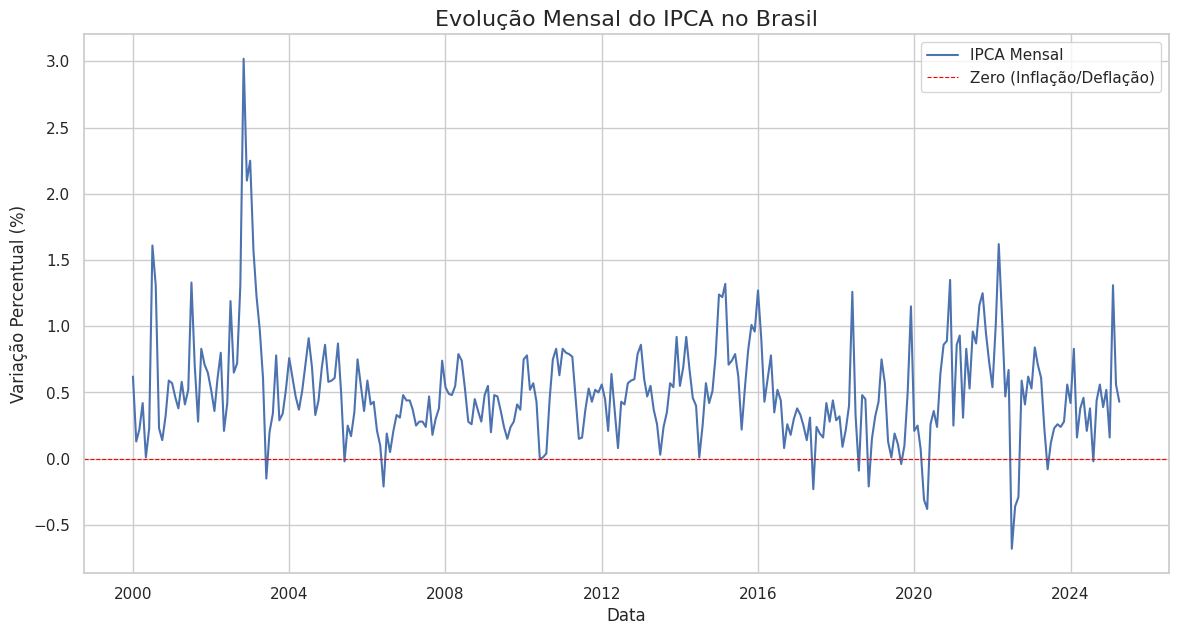

In [12]:

plt.figure(figsize=(14, 7))
plt.plot(ipca_dados.index, ipca_dados['IPCA'], label='IPCA Mensal')
plt.title('Evolução Mensal do IPCA no Brasil', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Variação Percentual (%)', fontsize=12)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero (Inflação/Deflação)')
plt.legend()

# Mostra o gráfico
plt.show()

### Visualização da Série Temporal do IPCA

O gráfico de linha acima exibe a trajetória do IPCA mensal desde 2000.
*Observações:*
* É possível identificar visualmente períodos de maior instabilidade inflacionária, como em 2002-2003, por volta de 2015-2016, e mais recentemente em 2021-2022, onde ocorreram picos mais acentuados.
* A linha tracejada em zero permite visualizar os meses de deflação, que foram relativamente poucos no período analisado.
* A série não parece apresentar uma tendência clara de crescimento ou queda constante ao longo de todo o período, mas sim flutuações e ciclos.

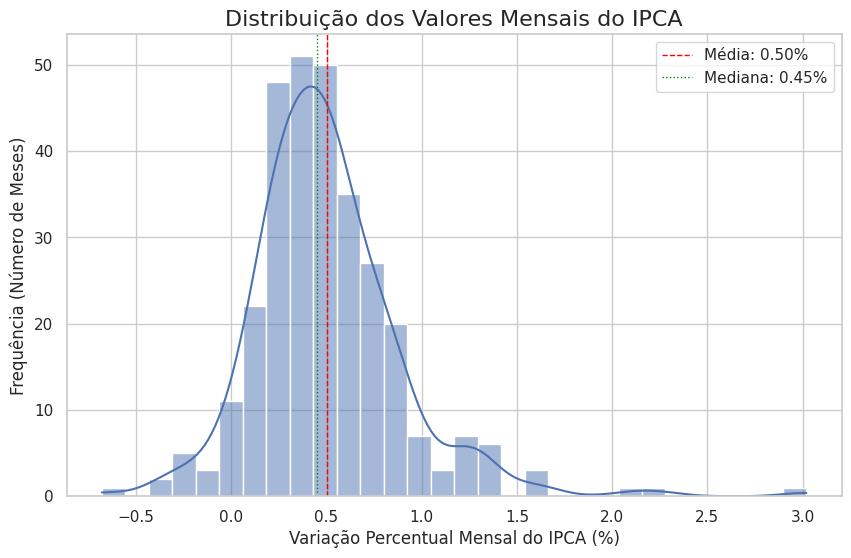

In [13]:

plt.figure(figsize=(10, 6))
sns.histplot(data=ipca_dados, x='IPCA', kde=True, bins=30)
plt.title('Distribuição dos Valores Mensais do IPCA', fontsize=16)
plt.xlabel('Variação Percentual Mensal do IPCA (%)', fontsize=12)
plt.ylabel('Frequência (Número de Meses)', fontsize=12)
plt.axvline(ipca_dados['IPCA'].mean(), color='red', linestyle='--', linewidth=1, label=f"Média: {ipca_dados['IPCA'].mean():.2f}%")
plt.axvline(ipca_dados['IPCA'].median(), color='green', linestyle=':', linewidth=1, label=f"Mediana: {ipca_dados['IPCA'].median():.2f}%")
plt.legend()

# Mostra o gráfico
plt.show()

### Distribuição dos Valores Mensais do IPCA

O histograma complementa a análise da série temporal, mostrando a frequência dos valores da inflação.
*Observações:*
* A distribuição é unimodal e apresenta uma leve assimetria positiva (à direita), como já sugerido pela diferença entre média e mediana. Isso significa que, embora a maioria dos valores se concentre em torno de 0.25% a 0.75%, houve alguns meses com inflação consideravelmente mais alta, estendendo a cauda direita da distribuição.
* A maior frequência de ocorrência (pico do histograma) parece estar na faixa de 0.4% a 0.5% de inflação mensal.
* As linhas da média (0.50%) e mediana (0.45%) estão marcadas, e a média ligeiramente à direita da mediana confirma a assimetria positiva.

## 3. Engenharia de Features

Para que um modelo de machine learning possa fazer previsões, ele precisa de variáveis de entrada, conhecidas como "features" (características ou variáveis explicativas). Neste estudo inicial, criarei features a partir dos valores passados da própria série do IPCA. Esses valores passados são comumente chamados de "lags" ou defasagens.

A hipótese é que o comportamento recente da inflação contém informação útil para prever seu valor no futuro próximo. Optei por utilizar os 3 lags anteriores (IPCA do mês t-1, t-2 e t-3) como features para prever o IPCA do mês t.

In [14]:
# Criando a feature IPCA do mês anterior (lag 1)
ipca_dados['IPCA_lag1'] = ipca_dados['IPCA'].shift(1)

# Criando a feature IPCA de 2 meses atrás (lag 2)
ipca_dados['IPCA_lag2'] = ipca_dados['IPCA'].shift(2)

# Criando a feature IPCA de 3 meses atrás (lag 3)
ipca_dados['IPCA_lag3'] = ipca_dados['IPCA'].shift(3)

# Vamos ver como ficou (especialmente o início da tabela)
print("DataFrame com lags (início):")
print(ipca_dados.head())

# E também o final da tabela
print("\nDataFrame com lags (final):")
print(ipca_dados.tail())

DataFrame com lags (início):
            IPCA  IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                             
2000-01-01  0.62        NaN        NaN        NaN
2000-02-01  0.13       0.62        NaN        NaN
2000-03-01  0.22       0.13       0.62        NaN
2000-04-01  0.42       0.22       0.13       0.62
2000-05-01  0.01       0.42       0.22       0.13

DataFrame com lags (final):
            IPCA  IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                             
2024-12-01  0.52       0.39       0.56       0.44
2025-01-01  0.16       0.52       0.39       0.56
2025-02-01  1.31       0.16       0.52       0.39
2025-03-01  0.56       1.31       0.16       0.52
2025-04-01  0.43       0.56       1.31       0.16


In [15]:
# Remove as linhas que contêm qualquer valor NaN
# inplace=True modifica o DataFrame ipca_dados diretamente
ipca_dados.dropna(inplace=True)

# Vamos verificar como ficou o início da tabela agora
print("DataFrame após remover NaNs (início):")
print(ipca_dados.head())

# E verificar as dimensões novamente
print("\nNovas dimensões do DataFrame:")
print(ipca_dados.shape)

DataFrame após remover NaNs (início):
            IPCA  IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                             
2000-04-01  0.42       0.22       0.13       0.62
2000-05-01  0.01       0.42       0.22       0.13
2000-06-01  0.23       0.01       0.42       0.22
2000-07-01  1.61       0.23       0.01       0.42
2000-08-01  1.31       1.61       0.23       0.01

Novas dimensões do DataFrame:
(301, 4)


A criação dos lags resulta em valores `NaN` (Not a Number) nas primeiras linhas do DataFrame, pois não existem dados anteriores para calcular os lags iniciais (por exemplo, para o primeiro mês da série, não há `IPCA_lag1`).
Essas linhas contendo `NaN` foram removidas utilizando o método `.dropna()`. Isso reduziu o número de observações de 304 para 301, mas é um passo necessário, pois os modelos de machine learning geralmente não lidam bem com dados ausentes.

### Definindo Features (X) e Variável Alvo (y)

Com os lags criados, o próximo passo é separar formalmente nosso DataFrame em:
* `X`: Uma matriz (ou DataFrame) contendo as features que o modelo usará para aprender. No nosso caso, serão as colunas `IPCA_lag1`, `IPCA_lag2` e `IPCA_lag3`.
* `y`: Um vetor (ou Série) contendo a variável alvo – o valor que queremos prever. No nosso caso, é a coluna `IPCA` (o valor "atual" da inflação que corresponde aos lags daquela linha).

In [16]:
# Lista com os nomes das colunas que serão nossas features
colunas_features = ['IPCA_lag1', 'IPCA_lag2', 'IPCA_lag3']

# Cria o DataFrame X selecionando apenas essas colunas
X = ipca_dados[colunas_features]

# Mostra as primeiras linhas de X para verificar
print("Primeiras linhas das Features (X):")
print(X.head())

Primeiras linhas das Features (X):
            IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                       
2000-04-01       0.22       0.13       0.62
2000-05-01       0.42       0.22       0.13
2000-06-01       0.01       0.42       0.22
2000-07-01       0.23       0.01       0.42
2000-08-01       1.61       0.23       0.01


In [17]:

y = ipca_dados['IPCA']
print("\nPrimeiras linhas da Variável Alvo (y):")
print(y.head())


Primeiras linhas da Variável Alvo (y):
Date
2000-04-01    0.42
2000-05-01    0.01
2000-06-01    0.23
2000-07-01    1.61
2000-08-01    1.31
Name: IPCA, dtype: float64


In [18]:
print("\nDimensões de X (features):")
print(X.shape)

print("\nDimensões de y (variável alvo):")
print(y.shape)


Dimensões de X (features):
(301, 3)

Dimensões de y (variável alvo):
(301,)


## 4. Treinamento do Modelo

Com as features e a variável alvo definidas, podemos prosseguir para o treinamento do modelo preditivo.

### Divisão em Dados de Treino e Teste
É uma prática fundamental em machine learning dividir os dados em um conjunto de treino (usado para "ensinar" o modelo) e um conjunto de teste (usado para avaliar o quão bem o modelo generaliza para dados novos, que ele não viu durante o treinamento).
Por se tratar de uma série temporal, a ordem dos dados é crucial. Portanto, a divisão será feita de forma cronológica: os dados mais antigos formarão o conjunto de treino, e os mais recentes, o conjunto de teste.

Decidi separar os últimos **24 meses** (2 anos) de dados para o conjunto de teste. O restante (277 meses) será utilizado para treino.

In [19]:

n_teste = 24

In [20]:
# X_treino recebe todas as linhas EXCETO as últimas 'n_teste' linhas
X_treino = X[:-n_teste]
# y_treino recebe todas as linhas EXCETO as últimas 'n_teste' linhas
y_treino = y[:-n_teste]

# X_teste recebe APENAS as últimas 'n_teste' linhas
X_teste = X[-n_teste:]
# y_teste recebe APENAS as últimas 'n_teste' linhas
y_teste = y[-n_teste:]

# Verificando as dimensões de cada conjunto
print("Dimensões de X_treino:", X_treino.shape)
print("Dimensões de y_treino:", y_treino.shape)
print("Dimensões de X_teste:", X_teste.shape)
print("Dimensões de y_teste:", y_teste.shape)

# Opcional: Olhar as últimas linhas do treino e primeiras do teste para confirmar a divisão
print("\nÚltimas 5 linhas de X_treino:")
print(X_treino.tail())
print("\nPrimeiras 5 linhas de X_teste:")
print(X_teste.head())

Dimensões de X_treino: (277, 3)
Dimensões de y_treino: (277,)
Dimensões de X_teste: (24, 3)
Dimensões de y_teste: (24,)

Últimas 5 linhas de X_treino:
            IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                       
2022-12-01       0.41       0.59      -0.29
2023-01-01       0.62       0.41       0.59
2023-02-01       0.53       0.62       0.41
2023-03-01       0.84       0.53       0.62
2023-04-01       0.71       0.84       0.53

Primeiras 5 linhas de X_teste:
            IPCA_lag1  IPCA_lag2  IPCA_lag3
Date                                       
2023-05-01       0.61       0.71       0.84
2023-06-01       0.23       0.61       0.71
2023-07-01      -0.08       0.23       0.61
2023-08-01       0.12      -0.08       0.23
2023-09-01       0.23       0.12      -0.08


### Treinando o Modelo de Regressão Linear

Para este primeiro exercício de modelagem, optei por utilizar a Regressão Linear. É um modelo fundamental, relativamente simples de implementar e interpretar, e serve como um bom ponto de partida (baseline) para comparar com modelos mais complexos no futuro.
O modelo tentará encontrar uma relação linear entre os lags do IPCA (features) e o IPCA do mês corrente (alvo).

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# Cria uma instância do modelo de Regressão Linear
modelo_linear = LinearRegression()

In [23]:
# Treina o modelo usando os dados de treino
modelo_linear.fit(X_treino, y_treino)

LinearRegression()

In [24]:
# Mostra o intercepto (o valor base da previsão quando todas as features são zero)
print("Intercepto do modelo:", modelo_linear.intercept_)

# Mostra os coeficientes aprendidos para cada feature (na ordem em que aparecem em X_treino)
print("Coeficientes do modelo:", modelo_linear.coef_)

# Para ver qual coeficiente corresponde a qual feature:
print("\nCoeficientes por feature:")
for feature, coef in zip(X_treino.columns, modelo_linear.coef_):
    print(f"{feature}: {coef:.4f}") # :.4f formata para 4 casas decimais

Intercepto do modelo: 0.18702883476100107
Coeficientes do modelo: [ 0.63998506 -0.05918929  0.05824135]

Coeficientes por feature:
IPCA_lag1: 0.6400
IPCA_lag2: -0.0592
IPCA_lag3: 0.0582


O modelo de Regressão Linear foi treinado com os dados de `X_treino` e `y_treino`. Os parâmetros aprendidos pelo modelo foram:
* Intercepto (β₀): `0.1870`
* Coeficientes (β₁, β₂, β₃) para os lags:
    * IPCA_lag1 (β₁): `0.6400`
    * IPCA_lag2 (β₂): `-0.0592`
    * IPCA_lag3 (β₃): `0.0582`

A equação do modelo seria, portanto:
`IPCA_previsto = 0.1870 + (0.6400 * IPCA_lag1) - (0.0592 * IPCA_lag2) + (0.0582 * IPCA_lag3)`

*Interpretação dos coeficientes:*
* O coeficiente de **0.6400** para `IPCA_lag1` é o de maior magnitude e positivo, sugerindo que a inflação do mês imediatamente anterior tem uma influência positiva e considerável na inflação do mês atual, conforme capturado pelo modelo.
* O coeficiente para `IPCA_lag2` é negativo (-0.0592) e relativamente pequeno, indicando uma leve influência negativa da inflação de dois meses atrás.
* O `IPCA_lag3` tem um coeficiente positivo (0.0582), também pequeno, sugerindo uma pequena influência positiva.
* É interessante notar a predominância do primeiro lag, o que é comum em séries temporais autoc correlacionadas.

## 5. Avaliação do Modelo

Com o modelo treinado, o próximo passo é utilizá-lo para fazer previsões sobre o conjunto de teste – dados que o modelo não viu durante o treinamento – e avaliar seu desempenho.

In [25]:
# Usa o modelo treinado para fazer previsões no conjunto de teste (X_teste)
previsoes_linear = modelo_linear.predict(X_teste)

In [26]:
# Mostra as primeiras 5 previsões
print("Primeiras 5 previsões do modelo linear:", previsoes_linear[:5])

# Mostra os primeiros 5 valores reais do conjunto de teste
# Usamos .values para mostrar apenas os números, facilitando a comparação visual
print("Primeiros 5 valores reais (y_teste):", y_teste[:5].values)

# Para uma comparação mais direta, podemos criar um pequeno DataFrame
# Isso é opcional, mas ajuda a visualizar lado a lado
df_comparacao = pd.DataFrame({'Real': y_teste.values, 'Previsto_Linear': previsoes_linear})
print("\nComparação lado a lado (primeiras linhas):")
print(df_comparacao.head())

Primeiras 5 previsões do modelo linear: [0.58431806 0.33947129 0.15774371 0.2819577  0.32246338]
Primeiros 5 valores reais (y_teste): [ 0.23 -0.08  0.12  0.23  0.26]

Comparação lado a lado (primeiras linhas):
   Real  Previsto_Linear
0  0.23         0.584318
1 -0.08         0.339471
2  0.12         0.157744
3  0.23         0.281958
4  0.26         0.322463


A tabela acima mostra as primeiras 5 previsões do modelo linear ao lado dos valores reais do IPCA para o conjunto de teste. Como esperado, as previsões não são idênticas aos valores reais. Por exemplo, para a primeira data do conjunto de teste (2023-05-01), o valor real foi 0.23% e o previsto foi 0.5843%.

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [28]:
# Calcula o MAE
mae_linear = mean_absolute_error(y_teste, previsoes_linear)
print(f"MAE do Modelo Linear: {mae_linear:.4f}")

# Calcula o MSE
mse_linear = mean_squared_error(y_teste, previsoes_linear)
print(f"MSE do Modelo Linear: {mse_linear:.4f}")

# Calcula o RMSE
rmse_linear = np.sqrt(mse_linear) # Raiz quadrada do MSE
print(f"RMSE do Modelo Linear: {rmse_linear:.4f}")

MAE do Modelo Linear: 0.2404
MSE do Modelo Linear: 0.1120
RMSE do Modelo Linear: 0.3347


### Métricas de Erro

Para uma avaliação quantitativa do desempenho do modelo no conjunto de teste, foram calculadas as seguintes métricas:
* MAE (Erro Absoluto Médio): `0.2404`
* MSE (Erro Quadrático Médio): `0.1120`
* RMSE (Raiz do Erro Quadrático Médio): `0.3347`

*Análise das métricas:*
* O MAE de **0.2404** indica que, em média, as previsões do modelo de Regressão Linear erraram por aproximadamente 0.24 pontos percentuais em relação ao valor real do IPCA mensal no período de teste.
* O RMSE, que é de **0.3347**, penaliza mais os erros maiores. O fato de ser um pouco superior ao MAE sugere a ocorrência de alguns erros de previsão de maior magnitude.
* Considerando que a inflação mensal frequentemente varia em décimos de ponto percentual, um erro médio dessa ordem pode ser considerado um ponto de partida, mas indica que há bastante espaço para melhorias no modelo.

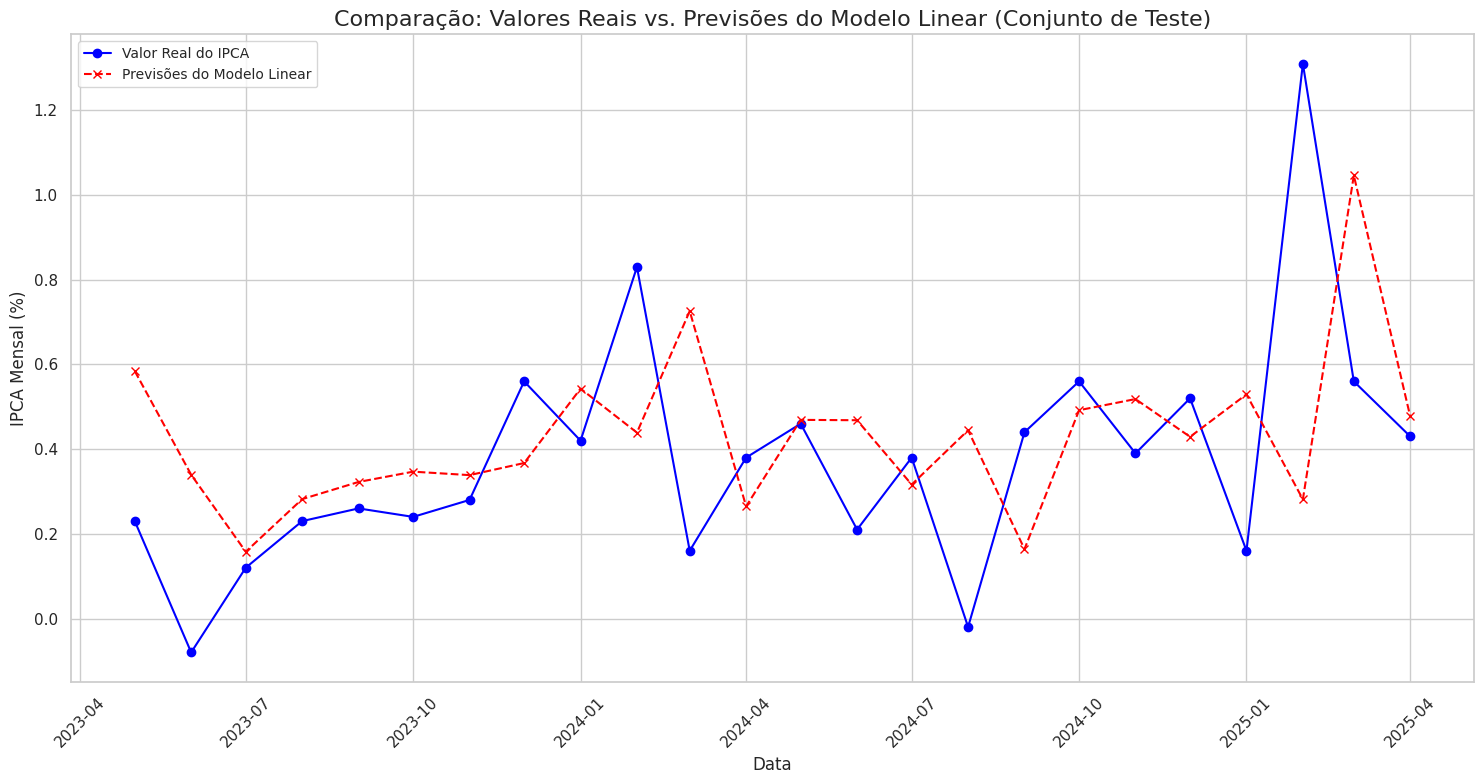

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 8) # Define o tamanho padrão das figuras

# Criando o gráfico
plt.plot(y_teste.index, y_teste.values, label='Valor Real do IPCA', color='blue', marker='o', linestyle='-')
plt.plot(y_teste.index, previsoes_linear, label='Previsões do Modelo Linear', color='red', marker='x', linestyle='--')

# Adicionando título e rótulos
plt.title('Comparação: Valores Reais vs. Previsões do Modelo Linear (Conjunto de Teste)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('IPCA Mensal (%)', fontsize=12)

# Adicionando legenda
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout() # Ajusta o plot para evitar que os rótulos se sobreponham

# Mostra o gráfico
plt.show()

### Visualização: Reais vs. Previstos

O gráfico acima permite uma comparação visual entre os valores reais do IPCA (linha azul) e as previsões geradas pelo modelo linear (linha vermelha tracejada) para o conjunto de teste.
*Observações:*
* A linha de previsão parece seguir a direção geral da inflação real em alguns momentos, mas tende a "suavizar" os movimentos, não capturando bem os picos e vales mais acentuados.
* Em certos períodos, como [observar no seu gráfico um período específico onde o erro é maior, ex: segundo semestre de 2023 ou início de 2024], a distância entre o previsto e o real é mais notável.
* O modelo parece ter uma tendência a [subestimar/superestimar] a inflação em momentos de [maior/menor] variação.

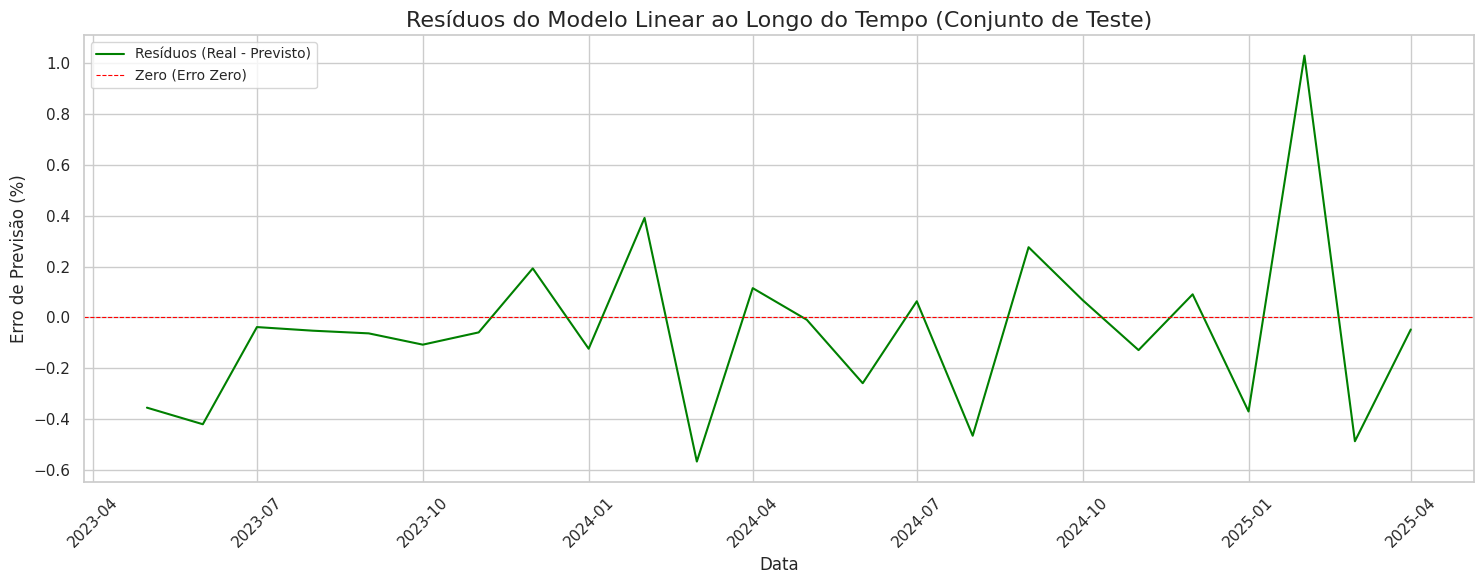

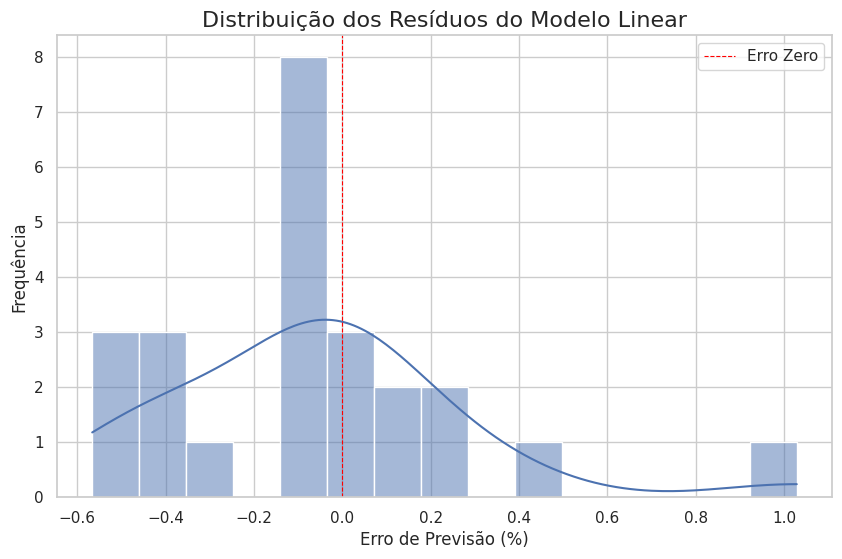

In [30]:

residuos_linear = y_teste.values - previsoes_linear
df_residuos = pd.DataFrame({'Data': y_teste.index, 'Residuos': residuos_linear})

# Plotando os resíduos ao longo do tempo
plt.figure(figsize=(15, 6))
plt.plot(df_residuos['Data'], df_residuos['Residuos'], label='Resíduos (Real - Previsto)', color='green', linestyle='-')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero (Erro Zero)') # Linha no erro zero

plt.title('Resíduos do Modelo Linear ao Longo do Tempo (Conjunto de Teste)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Erro de Previsão (%)', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograma dos resíduos (para ver se estão centrados em zero e se parecem normais)
plt.figure(figsize=(10, 6))
sns.histplot(residuos_linear, kde=True, bins=15)
plt.title('Distribuição dos Resíduos do Modelo Linear', fontsize=16)
plt.xlabel('Erro de Previsão (%)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.axvline(0, color='red', linestyle='--', linewidth=0.8, label='Erro Zero')
plt.legend()
plt.show()

### Análise dos Resíduos

A análise dos resíduos (diferença entre os valores reais e os previstos) é importante para verificar se o modelo está errando de forma sistemática.
*Observações:*
* O gráfico de resíduos ao longo do tempo não exibe um padrão muito claro ou persistente, embora haja alguns períodos com erros predominantemente positivos ou negativos. Idealmente, os resíduos deveriam flutuar aleatoriamente em torno de zero.
* O histograma dos resíduos mostra uma distribuição que parece se concentrar em torno de zero, com uma forma que se assemelha a uma distribuição normal, embora talvez com caudas um pouco mais pesadas, indicando a ocorrência de alguns erros maiores. A linha da média dos resíduos (se você a adicionou ou se o KDE está centrado) estar perto de zero é um bom indicativo.## 6. Conclusão e Próximos Passos

Neste projeto, foi desenvolvido um modelo inicial de Regressão Linear para prever a variação mensal do IPCA, utilizando como variáveis explicativas os seus três valores passados (lags).
O modelo, avaliado no conjunto de teste (últimos 24 meses da série), apresentou um Erro Absoluto Médio (MAE) de **0.2404 p.p.** e uma Raiz do Erro Quadrático Médio (RMSE) de **0.3347 p.p.**

Embora este seja um modelo bastante simples, ele serviu como um excelente exercício para percorrer todas as etapas de um projeto de modelagem de séries temporais, desde a coleta e tratamento dos dados, passando pela análise exploratória, engenharia de features, treinamento e avaliação do modelo.

*Principais aprendizados deste exercício:*
* A importância da análise exploratória para identificar características da série, como sua volatilidade e distribuição.
* A constatação de que, mesmo com features simples como os lags, é possível obter um modelo que aprende alguma relação nos dados, embora com limitações de precisão.
* A necessidade de métricas objetivas e visualizações para avaliar o desempenho do modelo de forma crítica.

*Sugestões para trabalhos futuros e melhorias no modelo:*
* **Engenharia de Features:** Incorporar variáveis macroeconômicas exógenas que sabidamente influenciam a inflação, como a taxa de juros (Selic), taxa de câmbio (USD/BRL), índices de atividade econômica, preços de commodities, etc.
* **Modelos Mais Avançados:** Experimentar modelos estatísticos clássicos para séries temporais, como ARIMA e SARIMA, ou algoritmos de machine learning mais sofisticados, como Random Forest, Gradient Boosting (XGBoost, LightGBM) ou até mesmo redes neurais (LSTMs).
* **Análise de Estacionariedade:** Verificar a estacionariedade da série do IPCA e aplicar transformações (como diferenciação) se necessário, pois muitos modelos performam melhor com séries estacionárias.
* **Validação Cruzada para Séries Temporais:** Implementar técnicas de validação cruzada apropriadas para dados temporais para uma avaliação mais robusta do modelo e para o ajuste de hiperparâmetros.

## 6. Conclusão e Próximos Passos

Neste projeto, foi desenvolvido um modelo inicial de Regressão Linear para prever a variação mensal do IPCA, utilizando como variáveis explicativas os seus três valores passados (lags).
O modelo, avaliado no conjunto de teste (últimos 24 meses da série), apresentou um Erro Absoluto Médio (MAE) de **0.2404 p.p.** e uma Raiz do Erro Quadrático Médio (RMSE) de **0.3347 p.p.**

Embora este seja um modelo bastante simples, ele serviu como um excelente exercício para percorrer todas as etapas de um projeto de modelagem de séries temporais, desde a coleta e tratamento dos dados, passando pela análise exploratória, engenharia de features, treinamento e avaliação do modelo.

*Principais aprendizados deste exercício:*
* A importância da análise exploratória para identificar características da série, como sua volatilidade e distribuição.
* A constatação de que, mesmo com features simples como os lags, é possível obter um modelo que aprende alguma relação nos dados, embora com limitações de precisão.
* A necessidade de métricas objetivas e visualizações para avaliar o desempenho do modelo de forma crítica.

*Futuras melhorias no modelo:*
* **Engenharia de Features:** Incorporar variáveis macroeconômicas exógenas que sabidamente influenciam a inflação, como a taxa de juros (Selic), taxa de câmbio (USD/BRL), índices de atividade econômica, preços de commodities, etc.
* **Modelos Mais Avançados:** Experimentar modelos estatísticos clássicos para séries temporais, como ARIMA e SARIMA, ou algoritmos de machine learning mais sofisticados, como Random Forest, Gradient Boosting (XGBoost, LightGBM) ou até mesmo redes neurais (LSTMs).
* **Análise de Estacionariedade:** Verificar a estacionariedade da série do IPCA e aplicar transformações (como diferenciação) se necessário, pois muitos modelos performam melhor com séries estacionárias.
* **Validação Cruzada para Séries Temporais:** Implementar técnicas de validação cruzada apropriadas para dados temporais para uma avaliação mais robusta do modelo e para o ajuste de hiperparâmetros.